# Mini Project 2 - Statistical Analysis and A/B Testing

## Packages and setup

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

### Reading data and initial processing

In [2]:
#Read data using pandas
user_df=pd.read_csv("Mini_project_2_Data.csv")

#Check data types of each column using "dtypes" function
print("Data types for the data set:")
user_df.dtypes

#Check dimension of data i.e. # of rows and #column using pandas "shape" funtion
print("Shape of the data i.e. no. of rows and columns")
user_df.shape

#display first 5 rows of the data using "head" function
print("First 5 rows of the raw data:")
user_df.head(5)

Data types for the data set:


userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Shape of the data i.e. no. of rows and columns


(90189, 5)

First 5 rows of the raw data:


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Exercise

## Q1. Detect and resolve problems in the data (Missing value, Outliers, etc.)

### Q1.1 Identify missing values

In [3]:
#Check for any missing values in the data using isnull() function
user_df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### Q1.2 Identify outliers

Text(0.5, 1.0, 'Total gamerounds played')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'sum_gamerounds')

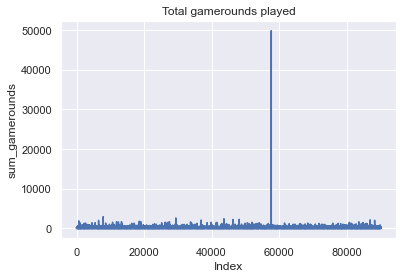

In [4]:
# Check for outlier values in sum_gamerounds column
sns.set()
plt.title("Total gamerounds played")
plt.xlabel("Index")
plt.ylabel("sum_gamerounds")
plt.plot(user_df.sum_gamerounds)

In [5]:
# Based on the plot, filter out the outlier from sum_gamerounds played; Use max() function to find the index of the outlier
outlier = user_df[['sum_gamerounds']].idxmax()
user_df_wo = user_df.drop(outlier)
user_df_wo.shape
user_df_wo

(90188, 5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


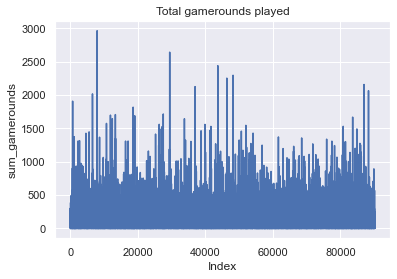

In [6]:
# Plot the graph for sum_gamerounds player after removing the outlier
plt.title("Total gamerounds played")
plt.xlabel("Index")
plt.ylabel("sum_gamerounds")
plt.plot(user_df_wo.sum_gamerounds);

## Q2. Plot summary statistics and identify trends to answer basic business questions

### Q2.1 What is the overall 7-day retention rate of the game?

In [7]:
retention_rate_7=user_df_wo['retention_7'].sum()/user_df_wo['retention_7'].count()*100
print("Overall 7 days retention rate of the game for both versions is: " ,round(retention_rate_7,2),"%")

Overall 7 days retention rate of the game for both versions is:  18.61 %


### Q2.2 How many players never played the game after installing? 

In [8]:
never_played = user_df_wo[user_df['sum_gamerounds'] == 0].shape[0]
print("The number of customers that never played the game after installing it is", never_played)

The number of customers that never played the game after installing it is 3994


### Q2.3 Does the number of users decrease as the level progresses highlighting the difficulty of the game?

<AxesSubplot:xlabel='sum_gamerounds'>

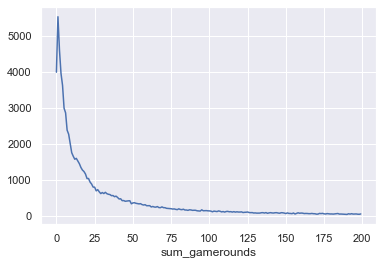

In [9]:
#Group by sum_gamerounds and count the number of users for the first 200 gamerounds
user_size = user_df_wo.groupby(['sum_gamerounds']).size().head(200)

#Use plot() function on the summarized stats to visualize the chart
user_size.plot()

<mark>__Assumption(s):__

Since data on game levels is not given, we assume that a player who has a higher number of sum gamerounds has progressed to higher levels.

<mark>__Analysis Results:__

Yes, the number of users decreases as the sum of game rounds increases, but only up until a certain number of game rounds. The largest drop out rate is observed for number of game rounds between 1 to 25.

However, the rate of decline decreases as the game progresses further, up until sum of game rounds = 75. Beyond sum of game rounds = 75, the rate of decline starts to plateau.

Together, these imply that it is not entirely true that the number of users decreases as the sum of game rounds progresses, since there is still a regular number of users playing the game as the sum of game rounds progress.

## Q3. Generate crosstab for two groups of players to understand if there is a difference in 7 days retention rate & total number of game rounds played

### Q3.1 Seven days retention rate summary for different game versions

In [10]:
#Create cross tab for game version and retention_7 flag counting number of users for each possible categories

pd.crosstab(user_df.version, user_df.retention_7).apply(lambda r: r/r.sum(), axis=1)

retention_7,False,True
version,,
gate_30,0.809799,0.190201
gate_40,0.818000,0.182000


<mark>__Analysis Results:__
    
It is observed that the user retention rate of both groups are similar. Placing the first gate at either level 30 or level 40 does not have a significant impact on user retention after 7 days.

### Q3.2 Gamerounds summary for different game versions

In [11]:
#use pandas group by to calculate average game rounds played summarized by different versions

user_df_wo.groupby(['version'])['sum_gamerounds'].mean()

version
gate_30    51.342111
gate_40    51.298776
Name: sum_gamerounds, dtype: float64

<mark>__Analysis Results:__
    
Here, we will check whether the total number of gamerounds played in total by each player differs based on different versions of the game. Since the average number of games played doesn't differ much between version A and version B, there is not a significant difference in the total number of levels played by both the versions.

## Q4. Perform two-sample test for groups A and B to test statistical significance amongst the groups in the sum of game rounds played i.e., if groups A and B are statistically different

### Initial data processing

In [12]:
#Define A/B groups for hypothesis testing

group_A=pd.DataFrame(user_df_wo[user_df_wo.version=="gate_30"]['sum_gamerounds'])
group_B=pd.DataFrame(user_df_wo[user_df_wo.version=="gate_40"]['sum_gamerounds'])

### Q4.1 Shapiro test of Normality

In [13]:
#---------------------- Shapiro Test ----------------------
# NULL Hypothesis H0: Distribution is normal
# ALTERNATE Hypothesis H1: Distribution is not normal    

# using alpha 0.05


#test for group_A
print("group_A")
stat,p = shapiro(group_A)
print('stat=%.3f, p=%.3f' % (stat,p))   #.3f means take only 3 values after decimal point
if p  > 0.05 :
    print('We fail to reject null hypothesis that states: Distribution is normal')
else :
    print('We reject the null hypothesis. Distribution is not normal')

print()

#test for group_B
print("group_B")
stat,p = shapiro(group_B)
print('stat=%.3f, p=%.3f' % (stat,p))
if p  > 0.05 :
    print('We fail to reject null hypothesis that states: Distribution is normal')
else :
    print('We reject the null hypothesis. Distribution is not normal')

group_A
stat=0.489, p=0.000
We reject the null hypothesis. Distribution is not normal

group_B
stat=0.483, p=0.000
We reject the null hypothesis. Distribution is not normal


In [14]:
group_A['sum_gamerounds'].max()

2961

<mark>__Analsysis Results:__
    
The data in both groups are not normally distributed. As such, non-parametric statistical tests should be used.

### Q4.2 Test of homogeneity of variance

In [15]:
#---------------------- Levene's Test ----------------------
# NULL Hypothesis H0: Two groups have equal variances
# ALTERNATE Hypothesis H1: Two groups do not have equal variances

# using alpha 0.05

#perform levene's test and accept or reject the null hypothesis based on the results
stat,p = stats.levene(group_A['sum_gamerounds'], group_B['sum_gamerounds'], center='median')
print('stat=%.3f, p=%.3f' % (stat,p))

if p > 0.05 :
    print('We fail to reject null hypothesis that states: Groups A and B have equal variances.')
else :
    print('We reject the null hypothesis. Groups A and B do not have equal variances.')

stat=0.075, p=0.784
We fail to reject null hypothesis that states: Groups A and B have equal variances.


<mark>__Analysis Results:__
    
Groups A and B exhibit homogeneity of variance.

### Q4.3 Test of significance: Two sample test

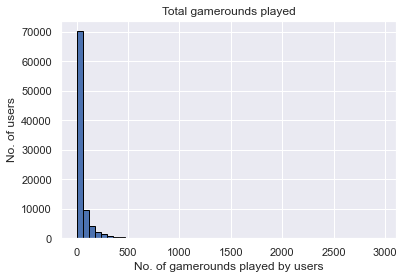

In [16]:
plt.title("Total gamerounds played")
plt.xlabel("No. of gamerounds played by users")
plt.ylabel("No. of users")
gamerounds = user_df_wo['sum_gamerounds']

plt.hist(gamerounds, bins = 50, edgecolor='black');

In [17]:
#---------------------- Two samples test ----------------------
# NULL Hypothesis H0: Distributions of the two samples are equal
# ALTERNATE Hypothesis H1: Distributions of the two samples are not equal

# using alpha 0.05

#Apply relevant two sample test to accept or reject the NULL hypothesis
stat,p = stats.ttest_ind(group_A, group_B)
print('stat=%.3f, p=%.3f' % (stat,p))

if p > 0.05 :
    print('We fail to reject null hypothesis that states: Distributions of the two samples are equal.')
else :
    print('We reject the null hypothesis. Distributions of the two samples are not equal.')

stat=0.063, p=0.949
We fail to reject null hypothesis that states: Distributions of the two samples are equal.


<mark>__Analsysis Results:__
    
The distributions of the two samples are equal.

## Q5. Based on significance testing results, if groups A and B are statistically different, which level has more advantage in terms of player retention and number of game rounds played

In [18]:
#Analyze the 1 day and 7 days retention rate for two different groups using group by function
user_df_wo.groupby(['version'])['retention_1'].mean()
user_df_wo.groupby(['version'])['retention_7'].mean()

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

<mark>__Analysis Results:__
    
Retention rate is not significantly different regardless of whether the first gate is placed at level 30 or level 40. Since number of players is observed to decline sharply between sum of game rounds 0 and 25, the first gate should be placed earlier on in the game so as to maximise potential in-game purchases.

## Q6. [Bonus Question]  Using bootstrap resampling, plot the retention rate distribution for both the groups inorder to visualize effect of different version of the game on retention.

In [19]:
gate30_1day = user_df_wo[(user_df_wo['version'] == 'gate_30')]['retention_1']
gate40_1day = user_df_wo[(user_df_wo['version'] == 'gate_40')]['retention_1']

gate30_7day = user_df_wo[(user_df_wo['version'] == 'gate_30')]['retention_7']
gate40_7day = user_df_wo[(user_df_wo['version'] == 'gate_40')]['retention_7']

In [20]:
# Collating 1day and 7day variables into lists
gates1day = [gate30_1day, gate40_1day]
gates7day = [gate30_7day, gate40_7day]

name_gates = ['gate 30', 'gate 40']

In [21]:
from sklearn.utils import resample
from random import randrange

# Package provided by BCG as a hint
def retention_function(gates1day, name_gates):
    count = 0
    x = []
    for j in gates1day:
        for i in range(100):
            boot = resample(j, replace=True, n_samples=10000, random_state=randrange(1000))
            x += [boot.mean()]
        sns.distplot(x, hist=False, kde=True, label=name_gates[count]);
        count += 1
    
    plt.legend(prop={'size': 10}, title='Version')
    plt.title('Density Plot for Retention Rate')
    plt.xlabel('Retention Rate')
    plt.ylabel('Density')

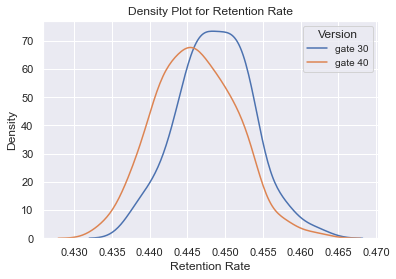

In [22]:
retention_function(gates1day, name_gates)

<mark>__Analysis Results:__
    
gate_30 has a similar 1-day retention rate to gate_40.

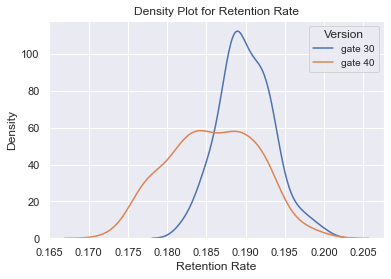

In [23]:
retention_function(gates7day, name_gates)

<mark>__Analysis Results:__

gate_30 has a marginally higher 7-day retention rate than gate_40.